<a href="https://colab.research.google.com/github/zsx711/AIPI-590/blob/main/notebook/AIPI_590_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #03


In this assignment, I use Exploratory Data Analysis to check assumptions about Linear, Logistic, and GAM models. And use these models to analyze the data from Telco Customer Churn [link](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code) and make model comparison. I use ChatGPT and class code demo [regression-interpretability.ipynb](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/interpretable-ml-example-notebooks/regression-interpretability.ipynb) and [generalized-models-interpretability.ipynb](https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/interpretable-ml-example-notebooks/generalized-models-interpretability.ipynb) as guidance.

Shunxin Zhang

Notebook:

# Data Prepartion

We will use the dataset from Telco Customer Churn [link](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code). Loading the dataset and identifying the structure. Spotting issues like missing or improperly formatted data.

In [80]:
!pip install pygam==0.9.1

In [91]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from pygam import LogisticGAM, s, f

In [92]:
# Check if the repository already exists, and remove it if so
repo_name = "AIPI-590"
if os.path.exists(repo_name):
    !rm -rf {repo_name}  # Remove the existing directory

# Clone GitHub repository (AIPI-590)
repo_name = "AIPI-590"
git_path = 'https://github.com/zsx711/AIPI-590.git'
!git clone "{git_path}"

# Change the working directory to 'notebook' inside your repo
notebook_dir = 'notebook'
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"

Cloning into 'AIPI-590'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 62 (delta 11), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 1.73 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/AIPI-590/notebook


In [82]:
# Upload the dataset manually in Colab
from google.colab import files
uploaded = files.upload()

# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Convert 'TotalCharges' to numeric, as it may contain non-numeric values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop missing values (rows where TotalCharges couldn't be converted)
df.dropna(inplace=True)

# Convert the target variable 'Churn' to 0 and 1 for numerical analysis
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Check for missing values and general info
df.info()
df.describe()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (17).csv
<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contr

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441,0.265785
std,0.368844,24.545260,30.085974,2266.771362,0.441782
min,0.000000,1.000000,18.250000,18.800000,0.000000
25%,0.000000,9.000000,35.587500,401.450000,0.000000
50%,0.000000,29.000000,70.350000,1397.475000,0.000000
75%,0.000000,55.000000,89.862500,3794.737500,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


Using countplot to identify distributions and relationships.

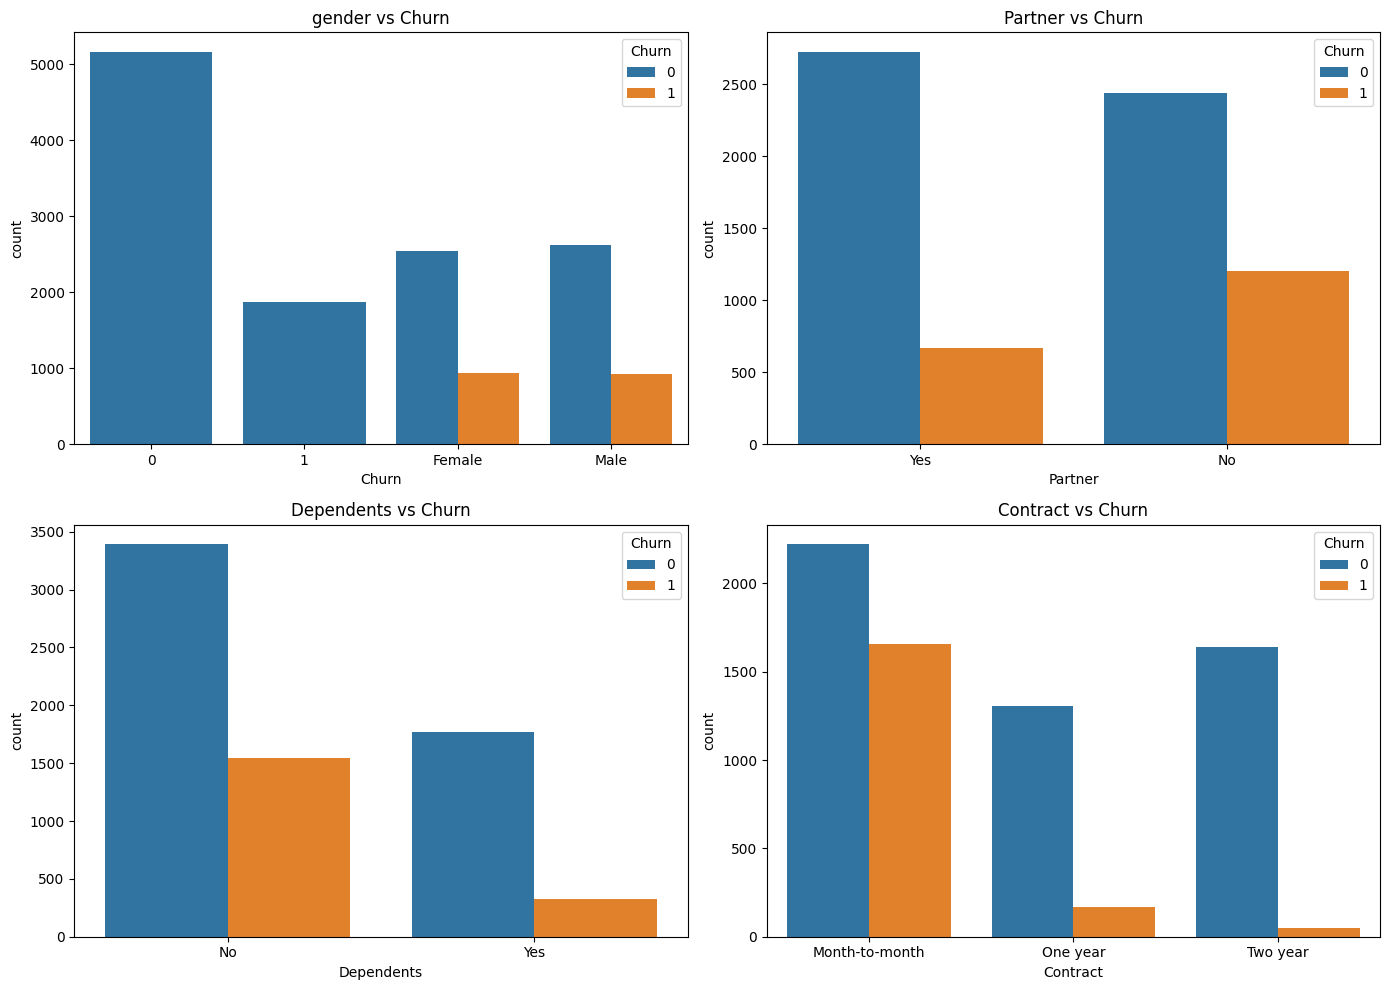

In [83]:
# Create a grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# List of categorical columns
categorical_cols = ['gender', 'Partner', 'Dependents', 'Contract']

# Plot churn count (without hue)
sns.countplot(data=df, x='Churn', ax=axes[0, 0])
axes[0, 0].set_title('Churn Distribution')

# Plot categorical variables against churn
for i, col in enumerate(categorical_cols):
    row, col_idx = divmod(i, 2)
    sns.countplot(data=df, x=col, hue='Churn', ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'{col} vs Churn')

# Adjust the layout to prevent overlapping of titles/labels
plt.tight_layout()
plt.show()



Using histogram, boxplot, and scatter plot to visualizing target variables and features.

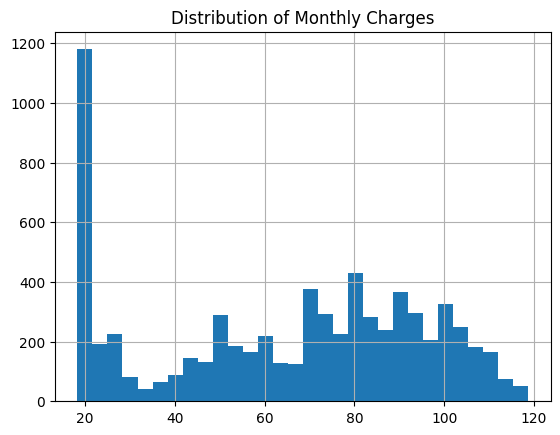

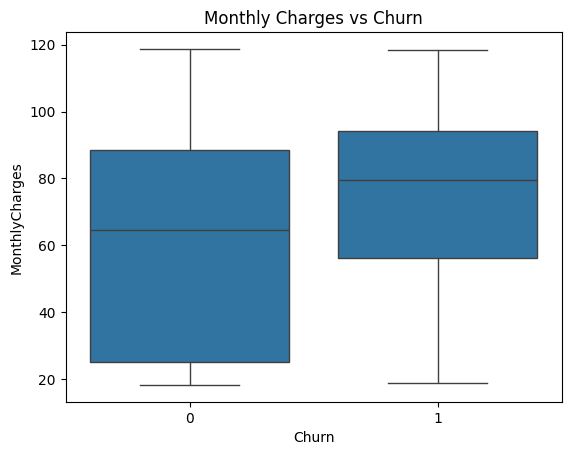

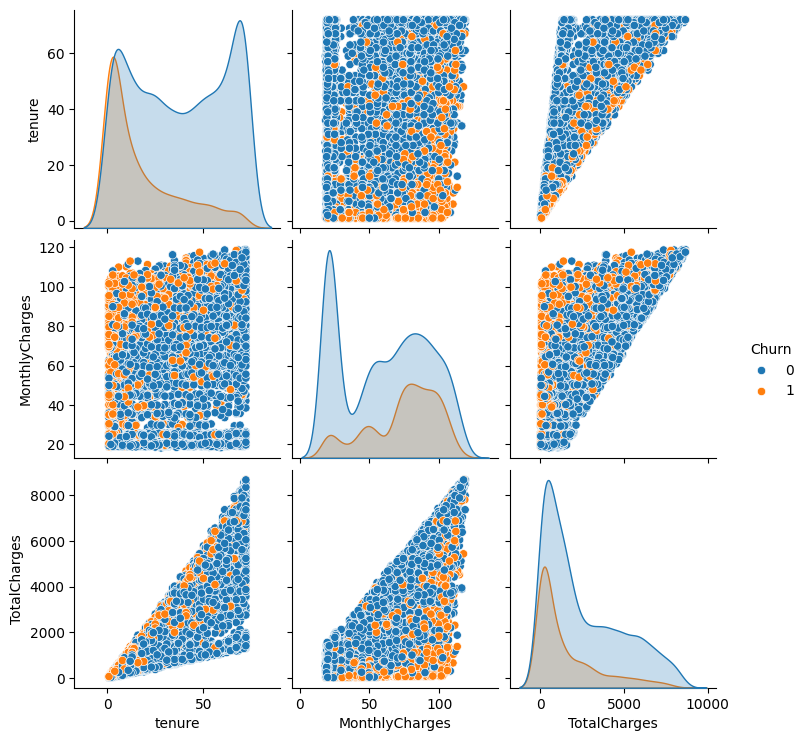

In [84]:
# Visualize the distribution of MonthlyCharges
df['MonthlyCharges'].hist(bins=30)
plt.title('Distribution of Monthly Charges')
plt.show()

# Box plot of MonthlyCharges by Churn
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

# Pair plot for numerical features vs Churn
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], hue='Churn')
plt.show()


Correlation Matrix for Numerical Variables

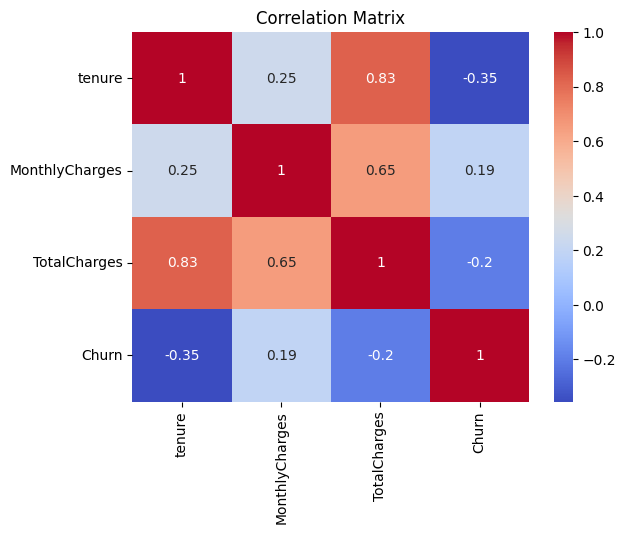

In [85]:
# Correlation Matrix and Heatmap
corr = df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr()

# Plot the correlation heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Check Assumptions About Linear Regression

1. Linearity:  The relationship between the independent variables and the target variable (churn) is not linear since churn is either 0 or 1.
2. Independence: Customer churn data is considered independent and don't show relationship with each other.
3. Homoscedasticity: The variance of residuals are not constant from the  residual plot, which indicates heteroscedasticity.
4. Normality: The histogram shows a nearly symmetric bell-shaped distribution and the Q-Q plot has residuals following the diagonal line, the normality assumption is met.
5. No Multicollinearity: The VIF of tenure and TotalCharges exceed 5, which indicates multicollinearity.
6. No Autocorrelation: The Durbin-Watson statistic is around 2, which indicates no autocorrelation.

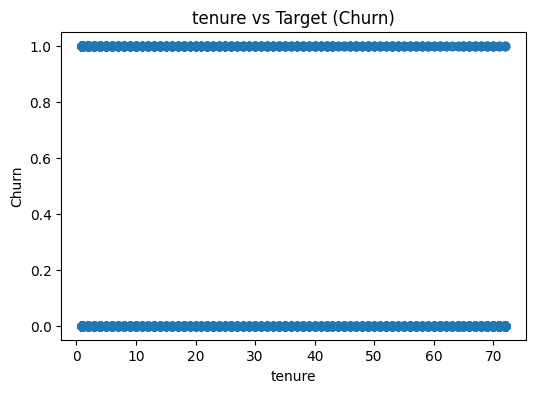

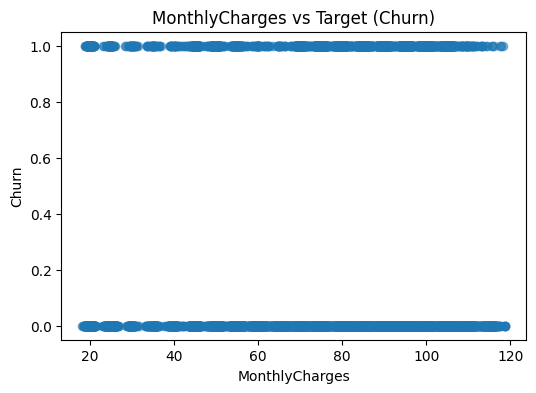

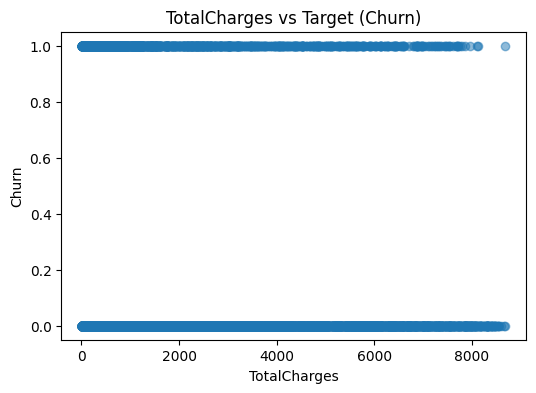

          Feature       VIF
0          tenure  6.332432
1  MonthlyCharges  3.361075
2    TotalCharges  8.079181


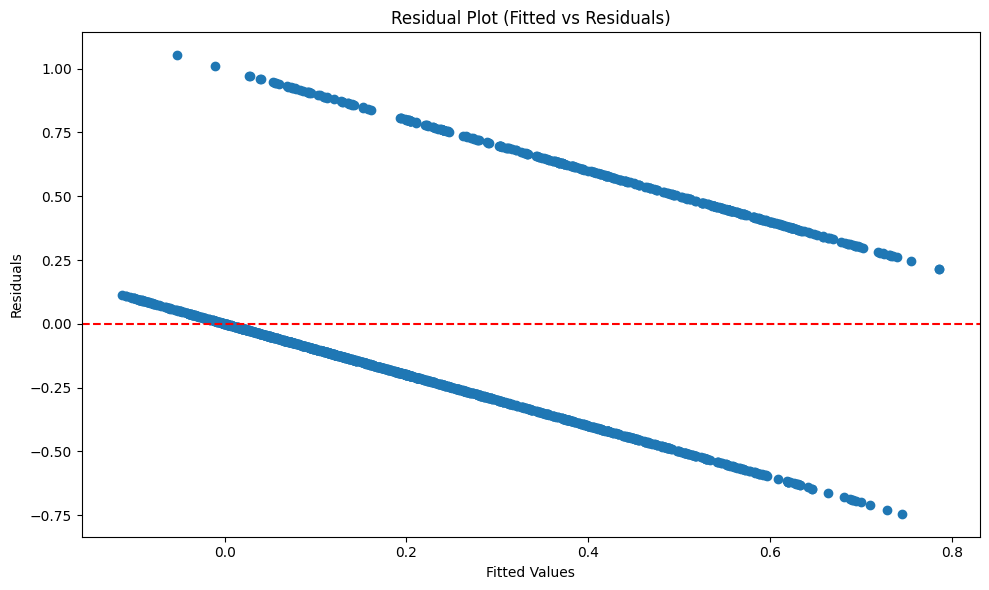

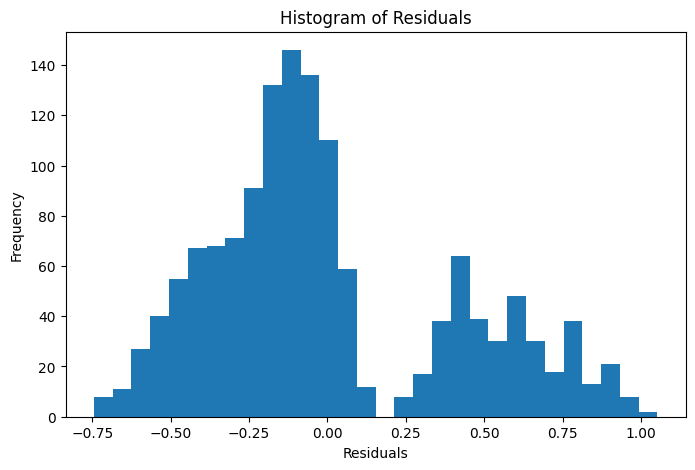

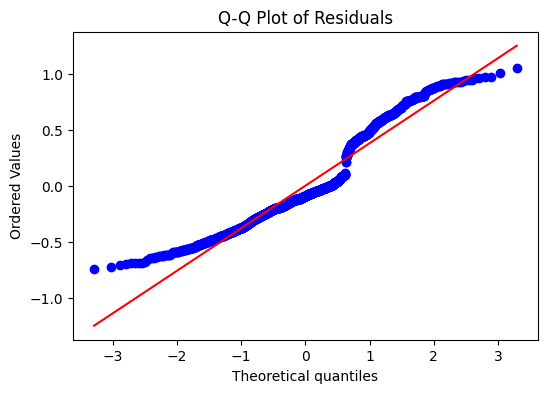

Durbin-Watson statistic: 1.9875844527924436


In [86]:
# Select numerical columns
X = df[['tenure', 'MonthlyCharges', 'TotalCharges']]
y = df['Churn']

# 1. Linearity Check
def plot_feature_vs_target(X, y):
    for column in X.columns:
        plt.figure(figsize=(6, 4))
        plt.scatter(X[column], y, alpha=0.5)
        plt.title(f'{column} vs Target (Churn)')
        plt.xlabel(column)
        plt.ylabel('Churn')
        plt.show()

plot_feature_vs_target(X, y)

# 2. Multicollinearity Check (VIF)
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_df = calculate_vif(X)
print(vif_df)

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

# 4. Homoscedasticity Check (Residual Plot)
def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residual Plot (Fitted vs Residuals)')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.tight_layout()
    plt.show()

plot_residuals(y_test, y_pred)

# 5. Normality of Residuals Check (Histogram and Q-Q Plot)
def plot_residual_histogram(residuals):
    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=30)
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

def plot_qq(residuals):
    plt.figure(figsize=(6, 4))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    plt.show()

residuals = y_test - y_pred
plot_residual_histogram(residuals)
plot_qq(residuals)

# 6. Autocorrelation Check (Durbin-Watson Test)
def check_autocorrelation(y_test, y_pred):
    residuals = y_test - y_pred
    dw_stat = durbin_watson(residuals)
    print(f"Durbin-Watson statistic: {dw_stat}")

check_autocorrelation(y_test, y_pred)


# Check Assumptions About Logistic Regression


1. Linearity of Log-Odds: Use p-values from the logistic regression output. Significant interaction terms indicate a violation of this assumption.
2. No Multicollinearity: The VIF of tenure and TotalCharges exceed 5, which indicates multicollinearity.
3. Independence: Customer churn data is considered independent and don't show relationship with each other.
4. No Influential Outliers: Cook's Distance greater than 1 , which indicates influential outliers.
5. No Perfect Separation: If the model converges without extreme coefficient values, there is no perfect separation.
6. Large Sample Size: The dataset has a large enough sample size (7043).

Optimization terminated successfully.
         Current function value: 0.453372
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7028
Method:                           MLE   Df Model:                            3
Date:                Thu, 19 Sep 2024   Pseudo R-squ.:                  0.2170
Time:                        11:53:30   Log-Likelihood:                -3188.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.5988      0.117    -13.628      0.000      -1.829      -1.369
tenure           

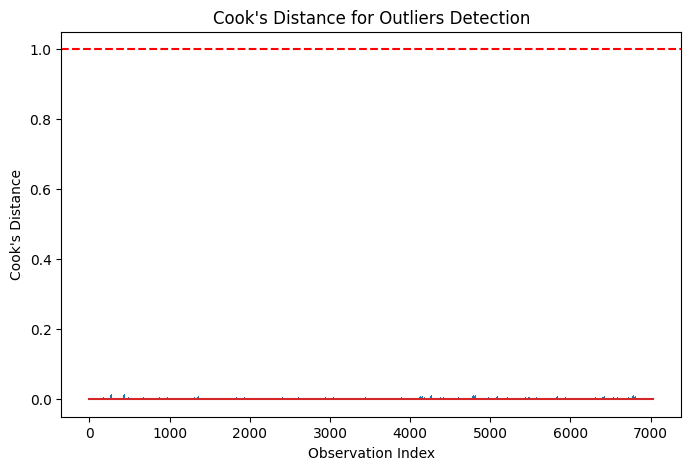

Influential points (Cook's Distance > 1): (array([], dtype=int64),)
Sample size: 7032


In [87]:
# 1. Linearity of Log-Odds
X_with_const = sm.add_constant(X)
logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit()
print(result.summary())

# 2. Multicollinearity Check (VIF)
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_df = calculate_vif(X)
print(vif_df)

# 4. Check for Influential Outliers (Cook's Distance)
influence = result.get_influence()
cooks_d = influence.cooks_distance[0]

# Plot Cook's Distance
plt.figure(figsize=(8, 5))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.title("Cook's Distance for Outliers Detection")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.axhline(1, color='red', linestyle='--')
plt.show()

influential_points = np.where(cooks_d > 1)
print(f"Influential points (Cook's Distance > 1): {influential_points}")

# 6. Large Sample Size
print(f"Sample size: {len(df)}")



# Check Assumptions About GAM




1. No Linearity: The previous analysis shows the relationship between the independent variables and the target variable (churn) is not linear. Assumption is met.

2. Multicollinearity: The VIF of tenure and TotalCharges exceed 5, which indicates multicollinearity.

3. Independence: Customer churn data is considered independent and don't show relationship with each other.

4. Homoscedasticity: The variance of residuals are not constant,  which indicates heteroscedasticity.

5. Large Sample Size: The dataset has a large enough sample size (7043).

# Implement Linear Regression Model

The linear regression model shows that tenure and total charges negatively impact customer churn, meaning that longer-term customers and those who have spent more over time are less likely to churn, with coefficients of -0.0655 and -0.1758, respectively. In contrast, higher monthly charges (coefficient of 0.2187) increase the likelihood of churn, indicating price sensitivity among customers. With a Mean Squared Error (MSE) of 0.1548 and an R-squared (R²) of 0.2072, the model captures around 20.7% of the variance in churn, suggesting that while pricing and customer tenure are important, additional factors may influence churn.

The linear regression model provides some useful insights, particularly regarding the impact of pricing and loyalty on churn. However, with a relatively low R², this model doesn't explain all the churn variance, indicating that additional features, interactions, or more complex models might be needed.


Linear Regression:
MSE: 0.1548
R2 Score: 0.2072
tenure: -0.0655
MonthlyCharges: 0.2187
TotalCharges: -0.1758


<Figure size 1000x600 with 0 Axes>

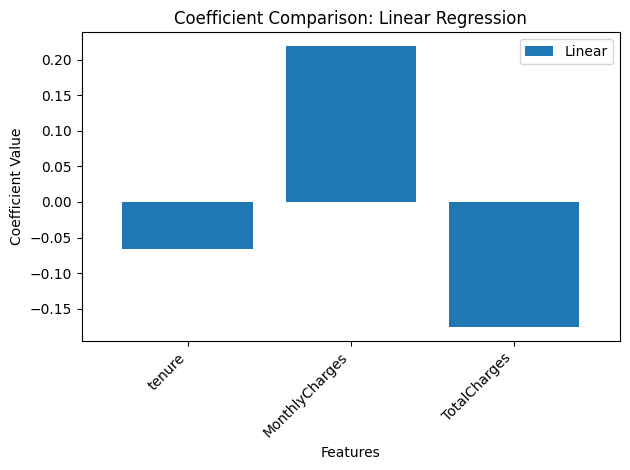

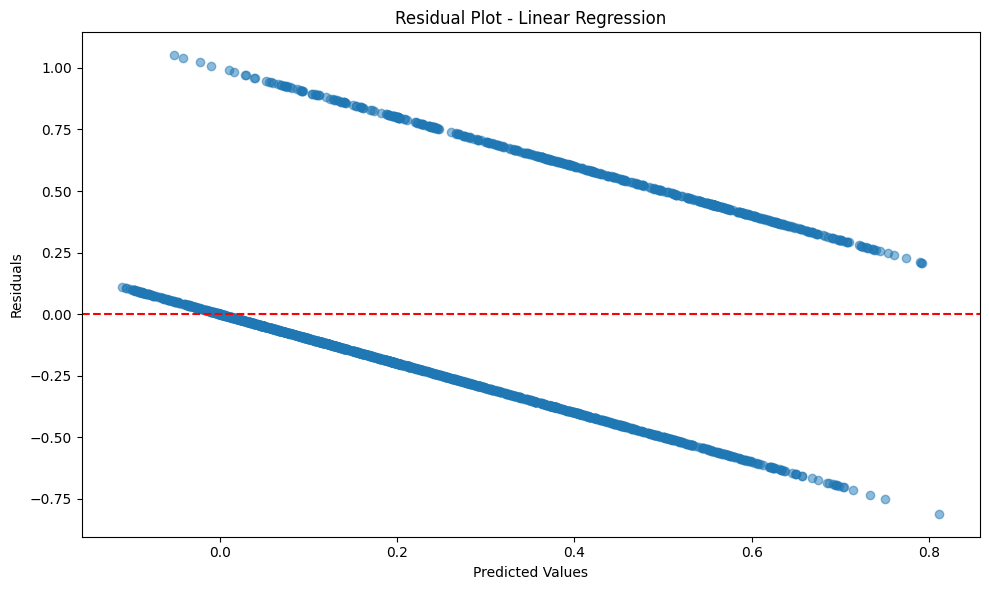

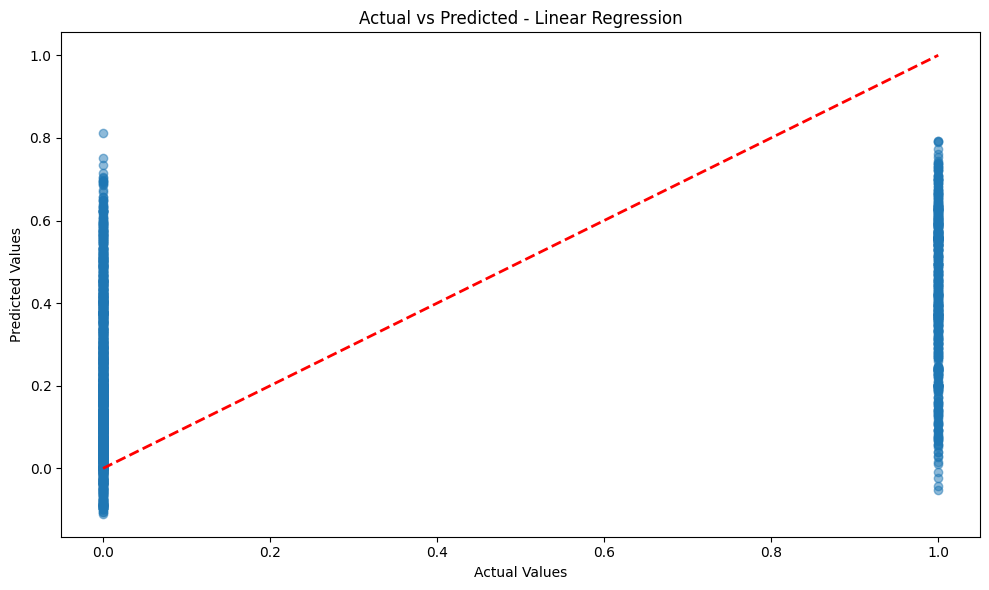

In [88]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    # Print coefficients
    for feature, coef in zip(X.columns, model.coef_):
        print(f"{feature}: {coef:.4f}")

    return model, y_pred

# Fit Linear Regression model
lr_model, lr_pred = evaluate_model(LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression")

# Plot Coefficients
def plot_coefficients(lr_model):
    coef_df = pd.DataFrame({
        'Linear': lr_model.coef_,
    }, index=X.columns)

    plt.figure(figsize=(10, 6))
    coef_df.plot(kind='bar', width=0.8)
    plt.title('Coefficient Comparison: Linear Regression')
    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.legend(loc='best')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot Residuals
def plot_residuals(y_test, y_pred, model_name):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {model_name}')
    plt.tight_layout()
    plt.show()

# Plot Actual vs Predicted
def plot_actual_vs_predicted(y_test, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {model_name}')
    plt.tight_layout()
    plt.show()

# Generate plots
plot_coefficients(lr_model)
plot_residuals(y_test, lr_pred, 'Linear Regression')
plot_actual_vs_predicted(y_test, lr_pred, 'Linear Regression')


# Implement Logistic Regression Model

The Logistic Regression model predicts the probability of customer churn using tenure, monthly charges, and total charges as features. The model's MSE of 0.2251 indicates a moderate level of prediction error, while the R² score of 0.2244 suggests that about 22.44% of the variance in churn can be explained by the model. The coefficient for tenure (-1.6639) shows that as a customer's tenure increases, the likelihood of churn decreases significantly. In contrast, MonthlyCharges (0.9384) has a positive coefficient, meaning higher monthly charges are associated with a higher probability of churn. TotalCharges (0.3223) also has a positive coefficient, but its impact is smaller, suggesting that overall spending may have a weaker influence on churn compared to monthly fees.

In conclusion, the model suggests that longer tenure reduces churn risk, while higher monthly charges increase it. The moderate R² score indicates that while these factors play an important role, there are likely other variables influencing churn that the model does not capture. Overall, logistic regression provides a reasonable understanding of the key drivers of customer churn, but further improvements could involve incorporating additional features or testing more complex models.

In [89]:
# Build and evaluate the Logistic Regression model
def evaluate_logistic_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predict the probabilities for class 1 (churn)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred_proba)  # Use probabilities for R-squared as we're predicting churn probability

    print(f"\n{model_name}:")
    print(f"MSE: {mse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    # Print coefficients
    for feature, coef in zip(X.columns, model.coef_[0]):
        print(f"{feature}: {coef:.4f}")

    return model, y_pred, y_pred_proba

# Fit Logistic Regression model
logistic_model, logistic_pred, logistic_pred_proba = evaluate_logistic_model(
    LogisticRegression(), X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression"
)


Logistic Regression:
MSE: 0.2251
R2 Score: 0.2244
tenure: -1.6639
MonthlyCharges: 0.9384
TotalCharges: 0.3223


# Implement GAM

The Generalized Additive Model (GAM) yielded a Mean Squared Error (MSE) of 0.2152, indicating the average squared difference between the actual and predicted churn outcomes. The R² score of 0.2485 suggests that about 24.85% of the variance in churn can be explained by the model. This result shows that the GAM model has captured some of the non-linear relationships between the customer features and churn, performing slightly better than the earlier logistic regression model, which captured about 22.44% of the variance. Features such as tenure, monthly charges, and total charges likely exhibit non-linear effects on the probability of churn, as revealed by the GAM’s ability to account for these more complex relationships.

In conclusion, the GAM model provides more flexibility in modeling the relationships between customer features and churn compared to linear models. Although the R² score indicates that the model captures a portion of the churn variance, there are likely additional features or interactions that could improve predictive power. The partial dependence plots generated from the GAM model offer useful insights into the non-linear effects of each feature, helping to identify specific trends and behaviors that may influence churn, making the model a better choice for understanding churn dynamics.


GAM Model Evaluation:
MSE: 0.2152
R2 Score: 0.2485


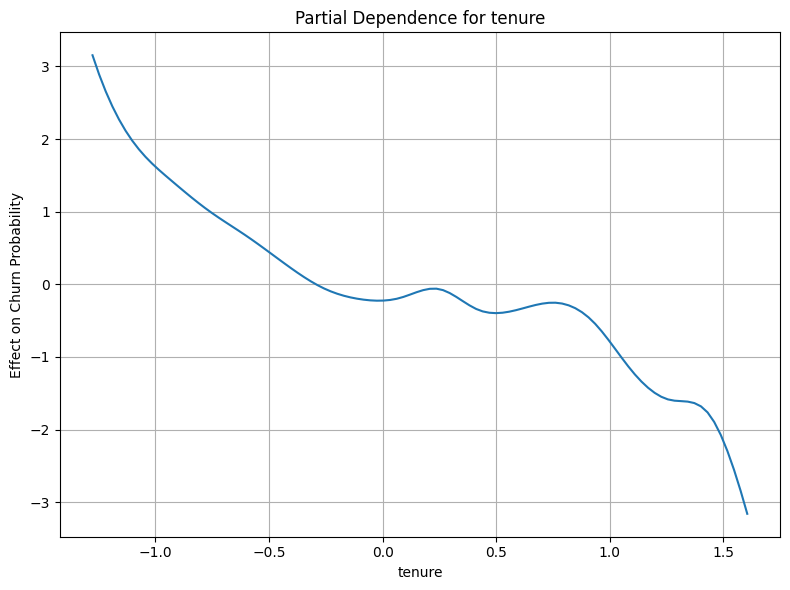

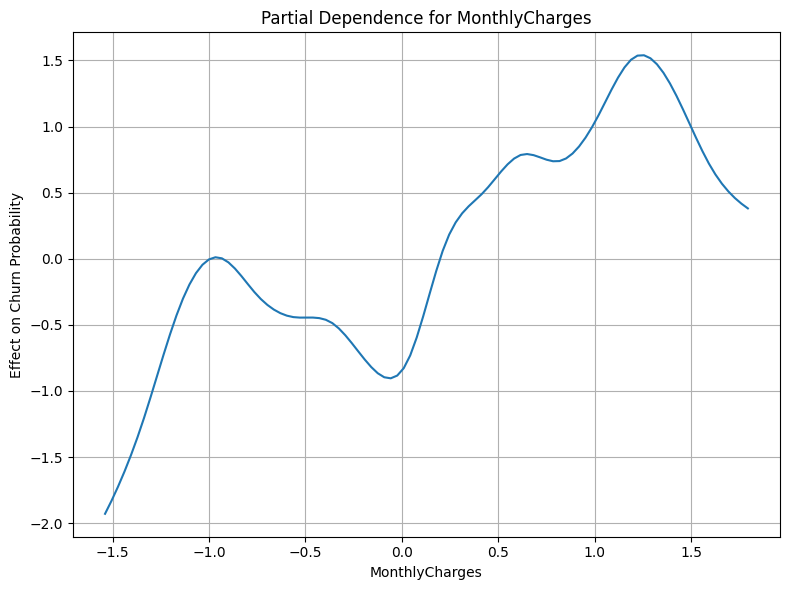

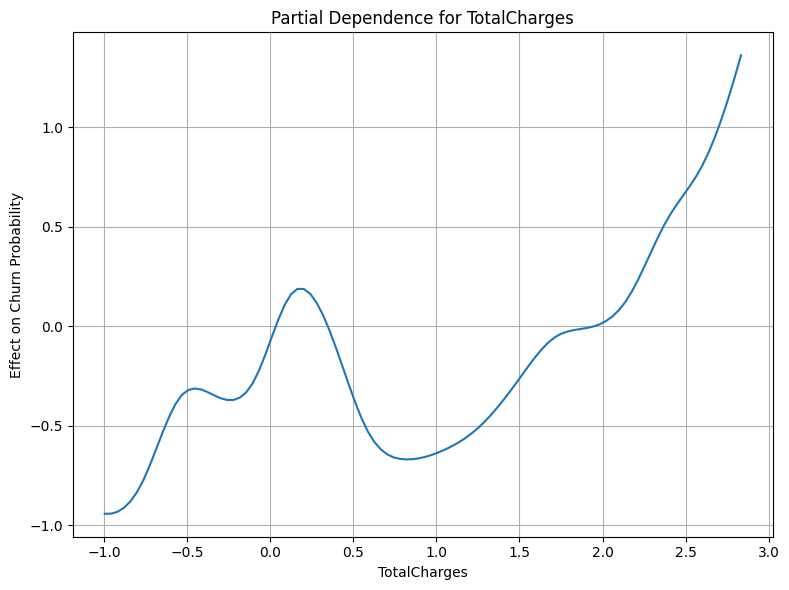

In [90]:
# Build a Generalized Additive Model (GAM)
gam = LogisticGAM(s(0) + s(1) + s(2))  # Using splines (s) for the features: tenure, MonthlyCharges, TotalCharges

# Train the GAM model
gam.fit(X_train_scaled, y_train)

# Make predictions using the GAM model
y_pred_gam = gam.predict(X_test_scaled)
y_pred_gam_proba = gam.predict_proba(X_test_scaled)

# Evaluate the GAM model
mse_gam = mean_squared_error(y_test, y_pred_gam)
r2_gam = r2_score(y_test, y_pred_gam_proba)

print(f"\nGAM Model Evaluation:")
print(f"MSE: {mse_gam:.4f}")
print(f"R2 Score: {r2_gam:.4f}")

# Plot the partial dependence plots for each feature to interpret the non-linear relationships
for i in range(X_train_scaled.shape[1]):  # Loop through each feature
    XX = gam.generate_X_grid(term=i)
    plt.figure(figsize=(8, 6))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f'Partial Dependence for {X.columns[i]}')
    plt.xlabel(f'{X.columns[i]}')
    plt.ylabel('Effect on Churn Probability')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Model Comparison

Linear Regression provides a straightforward interpretation of feature coefficients, allowing easy understanding of how variables like tenure and monthly charges impact churn, but it struggles with accuracy (MSE: 0.1548, R²: 0.2072) due to its assumption of a linear relationship between features and a binary outcome like churn. Logistic Regression, designed for binary classification, shows improved interpretability in terms of churn probability and better accuracy (MSE: 0.2251, R²: 0.2244). It reveals that tenure negatively impacts churn while monthly charges and total charges increase churn likelihood. However, it lacks the flexibility to capture non-linear patterns. Generalized Additive Model (GAM) provides flexibility in capturing non-linear relationships (MSE: 0.2152, R²: 0.2485), improving performance while offering interpretable partial dependence plots, but it can be harder to interpret than Logistic Regression for a non-technical audience.

The best model for the telecom corporation to handle client attrition would be logistic regression. It provides stakeholders with an easier way to comprehend which factors enhance or decrease the chance of churn by striking a solid mix between interpretability and accuracy. Even if GAM performs somewhat better, its complexity might not outweigh the little performance improvements, particularly if the objective is to offer useful information for corporate decision-making. For both technical and business teams looking to efficiently handle churn, logistic regression is the best option because it provides churn probabilities that are immediately actionable and allows for sufficient flexibility for feature analysis.